In [1]:
import numpy as np
import matplotlib.pyplot as plt

import math
import random
import os
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from tqdm import tqdm
from model import *
import torch
from torch.utils.data import random_split, DataLoader
import torchvision.transforms as transforms

from model import CNNBetaVAE, FCBetaVAE

from CelebADataSet import CelebADataSet
from ChairsDataSet import ChairsDataSet
from DSpritesDataSet import DSpritesDataSet
from FERGDataSet import FERGDataSet

from sklearn.manifold import TSNE
import os.path
from os import path

TRAINSET_PERECENTAGE = 0.8
np.random.seed(0)
torch.manual_seed(0)
random.seed(0)

In [2]:
class TorchModel:
    def __init__(self, model_name, model_path, model_instance, device):
        self.model_name = model_name
        self.model_path = model_path
        device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        model_instance = model_instance.to(device)
        model_instance.load_state_dict(torch.load(self.model_path))
        model_instance.eval()
        self.model = model_instance

    def set_reconstructions(self, reconstructions):
        self.reconstructions = reconstructions

In [3]:
def create_reconstuctions(testloader, models, device):
    for model in models:
        recons_lst = []
        with torch.no_grad():
            for data in testloader:
                images, labels = data
                images = images.to(device)
                recons,_,_ = model.model(images)
                images = images.detach().cpu()
                recons = recons.detach().cpu()
                recons_lst.append(recons)
        recons_tensor = torch.cat(recons_lst, dim=0)
        recons_arr = np.array(recons_tensor.permute(0,2,3,1))
        model.set_reconstructions(recons_arr)
    return models

In [24]:
def plot_reconstructions(models, testset, show=10, idxs=None, cmap='viridis', figsize=(20,8), save=None):
    fig, axs = plt.subplots(len(models)+1, figsize=figsize)
    total_images = len(models[0].reconstructions)
    if not idxs:
        idxs = np.random.randint(total_images, size=show)
    test_lst = [np.array(testset[i][0].permute(1,2,0).detach().cpu()) for i in idxs]
    original_imgs = np.concatenate(test_lst, axis=1)
    axs[0].imshow(original_imgs, cmap=cmap)
    axs[0].set_title('original images')
    axs[0].axis('off')

    for i, model in enumerate(models):
        imgs = model.reconstructions
        imgs = np.concatenate(imgs[idxs], axis=1)
        # imgs = (imgs * 255).astype(np.uint8)
        axs[i+1].imshow(imgs, cmap=cmap)
        axs[i+1].set_title(model.model_name)
        axs[i+1].axis('off')
    if save:
        plt.savefig(save)
    plt.show()



# Reconstructions

In the figures below, we compare qualitatively the disentangling performance of<br>different $\beta$ values over $10$ test-set samples from different datasets.<br>Each row represents a different $\beta$ value ($\beta = 1, 100, 250$),while the first row represents<br>the original images. Each figure is followed by a discussion of the models' results. 

## CelebA Testset Reconstructions

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


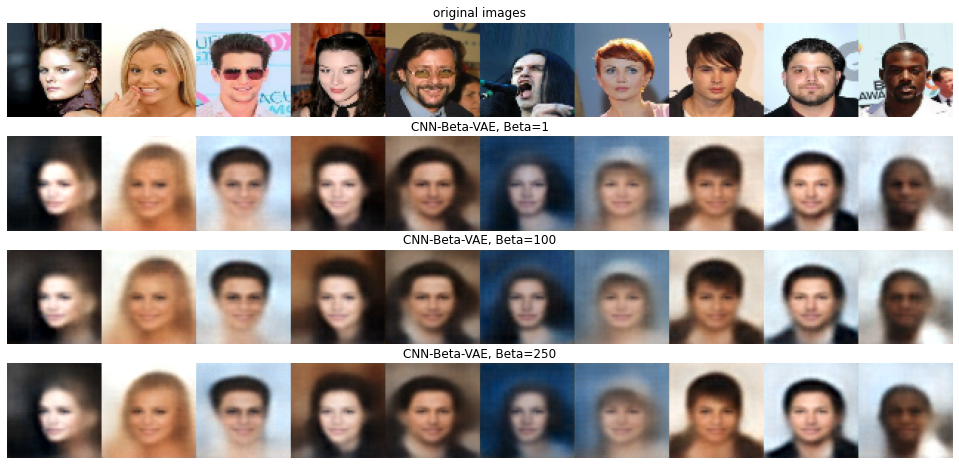

In [25]:
transform = transforms.Compose(
                [transforms.ToTensor(),
                transforms.Resize((64, 64))
                ]) # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

dataset = CelebADataSet(root_path='datasets/CelebA', transform=transform)

dataset_size = len(dataset)
trainset_size = int(dataset_size * 0.8)
testset_size = int(dataset_size - trainset_size)

trainset, testset = random_split(dataset, [trainset_size, testset_size], generator=torch.Generator().manual_seed(42))

test_size = len(testset)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

models_atts = [('CNN-Beta-VAE, Beta=1', 'models/CelebA/beta_1/epoch_10.pth'),
                ('CNN-Beta-VAE, Beta=100', 'models/CelebA/beta_100/epoch_10.pth'),
                ('CNN-Beta-VAE, Beta=250', 'models/CelebA/beta_250/epoch_10.pth')]

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

models = [TorchModel(model_name, model_path, CNNBetaVAE(latent_dim=32, in_channels=3), device) for model_name, model_path in models_atts]

idxs = [23563,  6356, 33930, 24451, 6004, 21533, 19996, 18930, 26981, 18504]
models = create_reconstuctions(testloader, models, device)
plot_reconstructions(models, testset, idxs=idxs, save='figures/CelebA_reconstructions.png')

The figure above shows the latent factors learnt by $\beta$-VAE on celebA dataset. Here are some cool facts we obtained from the above reconstructions:
1. All of the models got pretty similar reconstructions.
2. The models managed to learn the azimuth (rotation) of a person (Column 1).
3. The models remove unique features such as hands, sunglasses, beards and more. This is a bad thing because not only does it harms the reconstructions, but it also shows that the models cannot understand these generating factors.
4. The models managed to learn the generating factor - skin color. 

## Chairs Testset Reconstructions

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


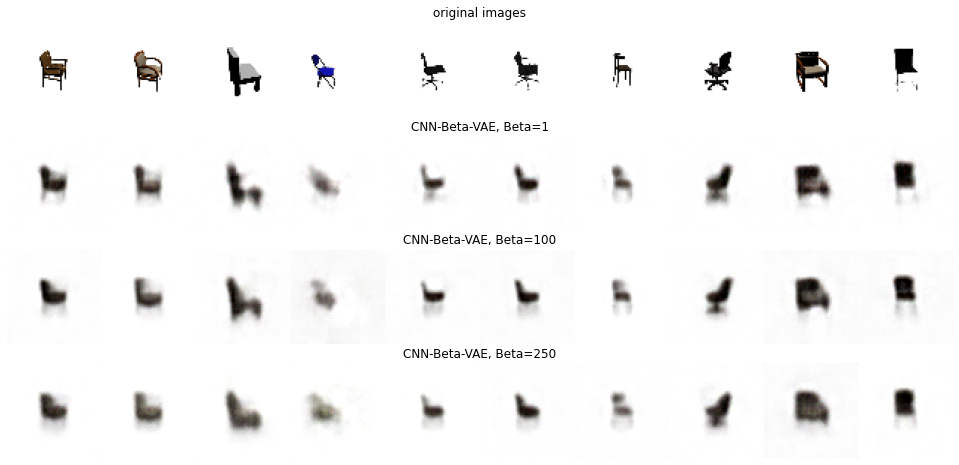

In [8]:
transform = transforms.Compose(
                [transforms.ToTensor(),
                transforms.Resize((64, 64))
                ]) # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

dataset = ChairsDataSet(root_path='datasets/rendered_chairs', transform=transform)

dataset_size = len(dataset)
trainset_size = int(dataset_size * 0.8)
testset_size = int(dataset_size - trainset_size)

trainset, testset = random_split(dataset, [trainset_size, testset_size], generator=torch.Generator().manual_seed(42))

test_size = len(testset)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

models_atts = [('CNN-Beta-VAE, Beta=1', 'models/Chairs/beta_1/epoch_10.pth'),
                ('CNN-Beta-VAE, Beta=100', 'models/Chairs/beta_100/epoch_10.pth'),
                ('CNN-Beta-VAE, Beta=250', 'models/Chairs/beta_250/epoch_10.pth')]

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

models = [TorchModel(model_name, model_path, CNNBetaVAE(latent_dim=32, in_channels=3), device) for model_name, model_path in models_atts]

models = create_reconstuctions(testloader, models, device)
plot_reconstructions(models, testset, idxs=None)

In the figure above, we compare qualitatively the disentangling performance of<br>different $\beta$ values over 10 test-set samples from the Chairs dataset. Overall, even though the reconstructions<br>are bit blurry, the models indeed managed to learn a lot of generating factors such as number of legs, base type, azimuth (rotation),<br>backrest type, chair scale and more.

## DSprites Testset Reconstructions

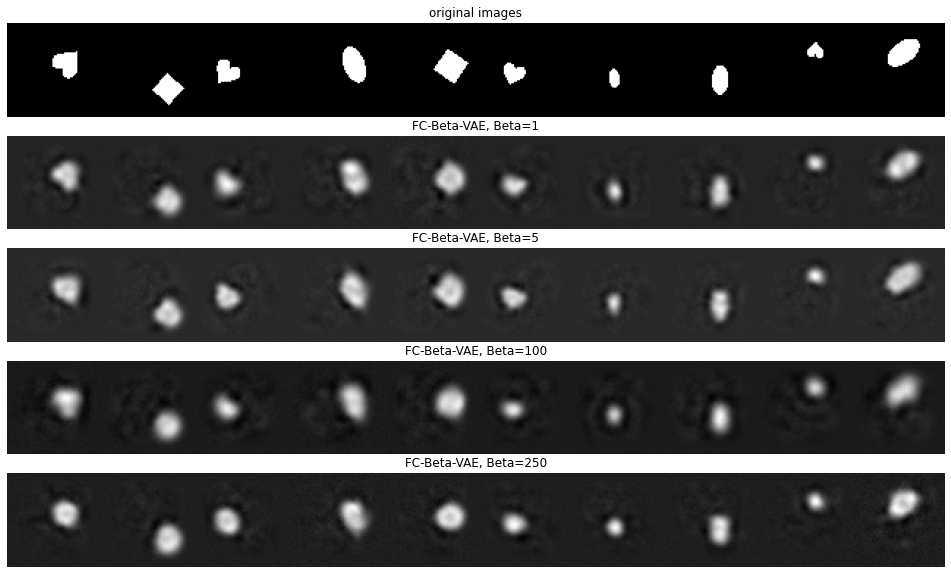

In [10]:
transform = transforms.Compose([])

dataset = DSpritesDataSet()
dataset_size = len(dataset)
trainset_size = int(dataset_size * 0.8)
testset_size = int(dataset_size - trainset_size)

trainset, testset = random_split(dataset, [trainset_size, testset_size], generator=torch.Generator().manual_seed(42))

test_size = len(testset)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

models_atts = [('FC-Beta-VAE, Beta=1', 'models/DSprites/beta_1/epoch_10.pth'),
                ('FC-Beta-VAE, Beta=5', 'models/DSprites/beta_5/epoch_10.pth'),
                ('FC-Beta-VAE, Beta=100', 'models/DSprites/beta_100/epoch_10.pth'),
                ('FC-Beta-VAE, Beta=250', 'models/DSprites/beta_250/epoch_10.pth')]

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

models = [TorchModel(model_name, model_path, FCBetaVAE(latent_dim=10, input_dim=4096), device) for model_name, model_path in models_atts]

models = create_reconstuctions(testloader, models, device)
plot_reconstructions(models, testset, idxs=None, cmap='gray', figsize=(20,10))


dSprites is a dataset of 2D shapes procedurally generated from 6 ground truth independent latent factors.<br>These factors are shape, scale, rotation, x and y positions of a sprite.<br>
All possible combinations of these latents are present exactly once, generating N = 737280 total images. <br>
Looking on the reconstructions, we can infer that our models managed to learn very weel the scale, and the x and y positions of the sprites. <br>
Even though we can notice some little differences between sprites shapes on the reconstructions, they are still not clear enough.<br>
The rotation of the sprites it little more vissible.
See Disentanglement Metric later in the notebook. 

## FERG Testset Reconstructions

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


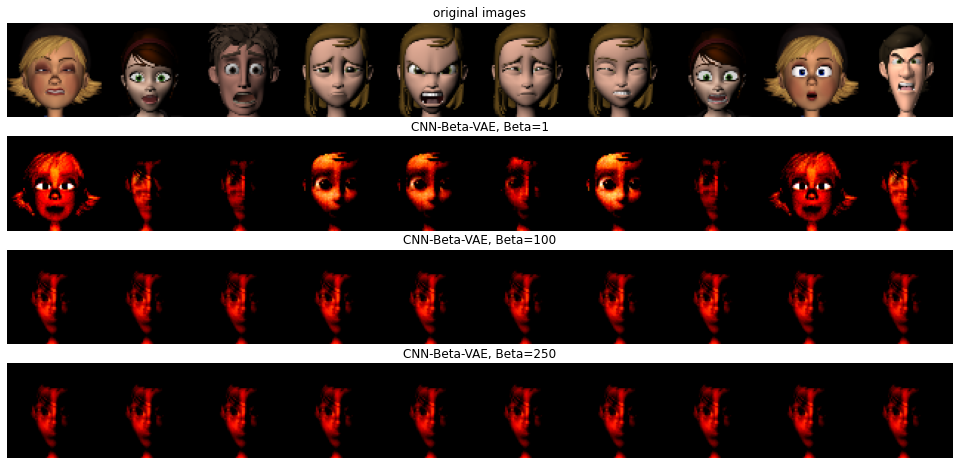

In [5]:
transform = transforms.Compose(
                [transforms.ToTensor(),
                transforms.Resize((64, 64))
                ]) # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

dataset =  FERGDataSet(transform=transform)
dataset_size = len(dataset)
trainset_size = int(dataset_size * 0.8)
testset_size = int(dataset_size - trainset_size)

trainset, testset = random_split(dataset, [trainset_size, testset_size], generator=torch.Generator().manual_seed(42))

test_size = len(testset)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

models_atts = [('CNN-Beta-VAE, Beta=1', 'models/FERG/beta_1/epoch_10.pth'),
                ('CNN-Beta-VAE, Beta=100', 'models/FERG/beta_100/epoch_10.pth'),
                ('CNN-Beta-VAE, Beta=250', 'models/FERG/beta_250/epoch_10.pth')]

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

models = [TorchModel(model_name, model_path, CNNBetaVAE(latent_dim=32, in_channels=3), device) for model_name, model_path in models_atts]

models = create_reconstuctions(testloader, models, device)
plot_reconstructions(models, testset, idxs=None)

Facial Expression Research Group 2D Database (FERG-DB) is a database of 2D images of stylized characters with annotated facial expressions.<br>The database contains 55767 annotated face images of six stylized characters. The characters were modeled using the MAYA software and rendered out in 2D to create the images. The images for each character are grouped into seven types of expressions - anger, disgust, fear, joy, neutral, sadness and surprise.

The VAE (Beta=1) model managed to capture the character and its facial features such as eyes, nose, hair, and more.
Unfortunately, all of the models could not capture emotions, and the Beta-VAEs (100,250) could not even reconstruct the character itself.
Weirdly, all of the models could not capture the colors of the original image.

## Disentanglement Metric 

In [6]:
from evaluate import disentanglement_metric_score

In [9]:
dataset_size=1000
num_epochs=1000
L=64
disen_metric_models = [('FC-Beta-VAE, Beta=1','models/DSprites/beta_1/epoch_10.pth'),
                        ('FC-Beta-VAE, Beta=5','models/DSprites/beta_5/epoch_10.pth'),
                        ('FC-Beta-VAE, Beta=25','models/DSprites/beta_25/epoch_10.pth'),
                        ('FC-Beta-VAE, Beta=50','models/DSprites/beta_50/epoch_10.pth'),
                        ('FC-Beta-VAE, Beta=100','models/DSprites/beta_100/epoch_10.pth'),
                        ('FC-Beta-VAE, Beta=250','models/DSprites/beta_250/epoch_10.pth'),
                        ('FC-Beta-VAE, Beta=500','models/DSprites/beta_500/epoch_10.pth')]
scores = {}
for model in disen_metric_models:
    scores[model[0]] = disentanglement_metric_score(model_path=model[1], dataset_size=dataset_size, L=L, num_epochs=num_epochs)

In [10]:
for model in scores:
    print(f'Model: {model}%, Disentanglement metric score: {scores[model]}')

Model: FC-Beta-VAE, Beta=1, Disentanglement metric score: 87.5
Model: FC-Beta-VAE, Beta=5, Disentanglement metric score: 89.0
Model: FC-Beta-VAE, Beta=25, Disentanglement metric score: 85.5
Model: FC-Beta-VAE, Beta=50, Disentanglement metric score: 80.5
Model: FC-Beta-VAE, Beta=100, Disentanglement metric score: 83.5
Model: FC-Beta-VAE, Beta=250, Disentanglement metric score: 78.0
Model: FC-Beta-VAE, Beta=500, Disentanglement metric score: 76.5


The best model, disentanglement-wise, is the Fully-Connected Beta-VAE with Beta=5!<br>
Achieving the highest accuracy of 89.0% !

## Latent Space

Since our datasets contains a lot of generating factors, it is not necessarily meaningful to look at their 2D-latents space.
<br>We present here the latent spaces - some with labels, some without, due to data accecability.<br>
Indeed, all of the spaces are not clustered and it is really hard to find paterns in them.

In [11]:
def get_latents_labels_lists(model, dataset):
    latents = []
    labels = []
    for idx in range(len(dataset)):
        img, label = dataset[idx]
        latent_rep,_,_ = model.encode(img.unsqueeze(dim=0).to(device)) 
        latents.append(np.asarray(latent_rep.detach().cpu())[0])
        if dataset == "DSprites":
            label = label[0]
            
        labels.append(label)
        if idx == 5_000: break
    return latents, labels

def plot_embedding(embeded_x, dataset_name, model_name, embedded_method, labels=[]):
    fig, ax = plt.subplots()
    if np.unique(np.unique(np.array(labels)).shape[0]) <= 1:
        ax.scatter(embeded_x[:,0], embeded_x[:,1])
    else:
        for g in np.unique(labels):
            idx = np.where(labels == g)
            ax.scatter(embeded_x[:,0][idx], embeded_x[:,1][idx], label=g)
    ax.legend()
    plt.title(f'{embedded_method}- dataset: {dataset_name}, model: {model_name}')
    plt.show()

def get_results_by_model_name(dataset_name, beta, epoch = 10, embedded_method='TSNE'):
    
    saved_model = f'beta_{beta}/epoch_{epoch}.pth'
    
    if dataset_name == 'CelebA':
        transform = transforms.Compose(
                [transforms.ToTensor(),
                transforms.Resize((64, 64))
                ])
        dataset = CelebADataSet(root_path=f'datasets/CelebA', transform=transform)
        model = CNNBetaVAE(latent_dim=32, in_channels=3)
    
    elif dataset_name == 'FERG':
        transform = transforms.Compose(
        [transforms.ToTensor(),
        transforms.Resize((64, 64))
        ])
        dataset = FERGDataSet(transform=transform)
        model = CNNBetaVAE(latent_dim=32, in_channels=3)

    elif dataset_name == 'DSprites':
        dataset = DSpritesDataSet()
        model = FCBetaVAE(latent_dim=10, input_dim=4096)

    elif dataset_name == 'Chairs':
        transform = transforms.Compose(
                [transforms.ToTensor(),
                transforms.Resize((64, 64))
                ])
        dataset = ChairsDataSet(transform=transform)
        model = CNNBetaVAE(latent_dim=32, in_channels=3)
    dataset_size = len(dataset)
    trainset_size = int(dataset_size * TRAINSET_PERECENTAGE)
    _, testset = random_split(dataset,
                                [trainset_size, dataset_size - trainset_size],
                                generator=torch.Generator().manual_seed(42))
                                
    model = model.to(device)
    model.load_state_dict(torch.load(f'models/{dataset_name}/{saved_model}'))
    model.eval()
    latents, labels = get_latents_labels_lists(model, testset)
    if embedded_method == 'TSNE':
        print('TSNE...')
        embedding = np.array(TSNE(n_components=2, init='random').fit_transform(np.array(latents)))
    else:
        print('PCA...')
        embedding = PCA(n_components=2, whiten=True, svd_solver='full').fit(latents)

    latents_dir_path = 'latents'
    labels_dir_path = 'labels'
    embedded_dir_path = 'embedded'
    
    if not path.exists(latents_dir_path):
        os.mkdir(latents_dir_path)

    np.save(os.path.join(latents_dir_path, f'{dataset_name}_latents.npy'), latents)
    
    if not path.exists(embedded_dir_path):
        os.mkdir(embedded_dir_path)
    
    np.save(os.path.join(embedded_dir_path, f'{dataset_name}_{embedded_method}_beta={beta}_epoch={epoch}.npy'), embedding)
    
    if not path.exists(labels_dir_path):
        os.mkdir(labels_dir_path)

    np.save(os.path.join(labels_dir_path, f'{dataset_name}_labels.npy'), labels)
    
    if dataset_name == 'Chairs':
        labels = []        

    plot_embedding(embedding, dataset_name, saved_model, embedded_method = f'{embedded_method}- Epoch: {epoch}, Beta: {beta}' , labels = labels)


 12%|█▏        | 5000/40520 [00:15<01:53, 313.05it/s]


TSNE...


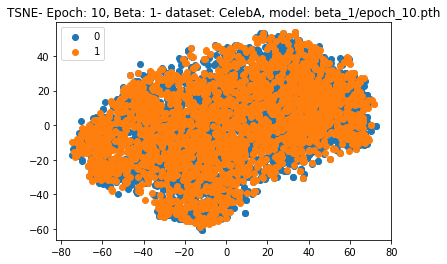

 12%|█▏        | 5000/40520 [00:15<01:51, 319.21it/s]


TSNE...


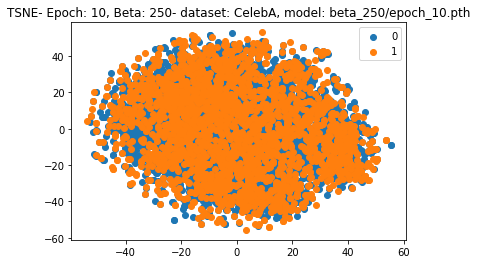

 29%|██▉       | 5000/17274 [00:39<01:37, 125.89it/s]


TSNE...


No handles with labels found to put in legend.


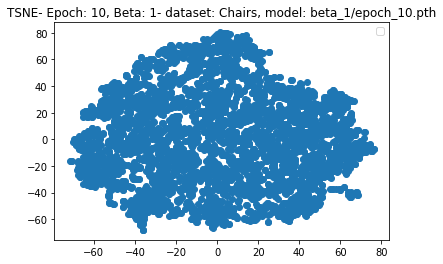

 29%|██▉       | 5000/17274 [00:39<01:37, 125.75it/s]


TSNE...


No handles with labels found to put in legend.


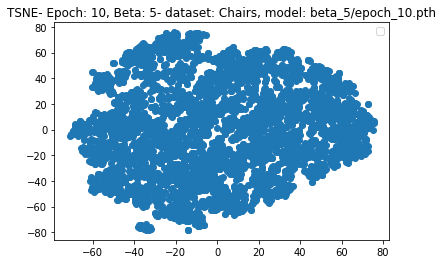

  3%|▎         | 5000/147456 [00:03<01:25, 1658.82it/s]


TSNE...


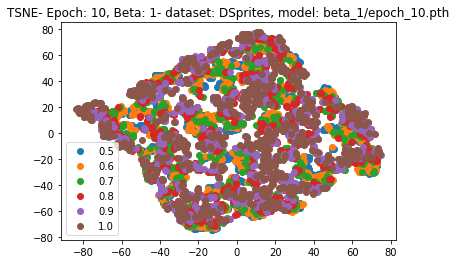

  3%|▎         | 5000/147456 [00:03<01:25, 1660.57it/s]


TSNE...


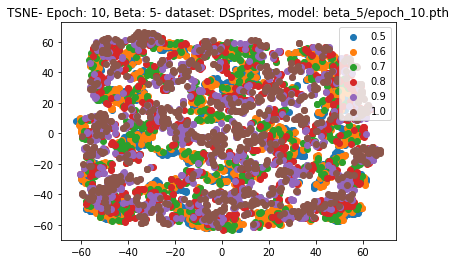

  3%|▎         | 5000/147456 [00:02<01:25, 1670.85it/s]


TSNE...


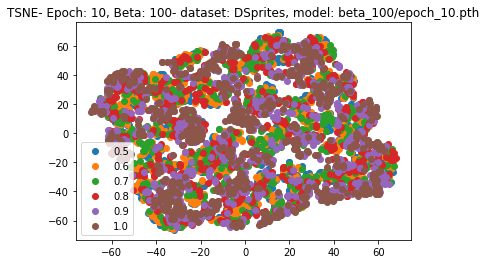

 45%|████▍     | 5000/11154 [00:23<00:28, 212.69it/s]


TSNE...


No handles with labels found to put in legend.


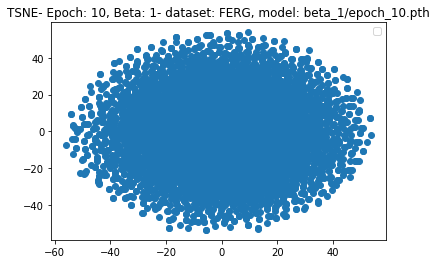

 45%|████▍     | 5000/11154 [00:22<00:28, 218.50it/s]


TSNE...


No handles with labels found to put in legend.


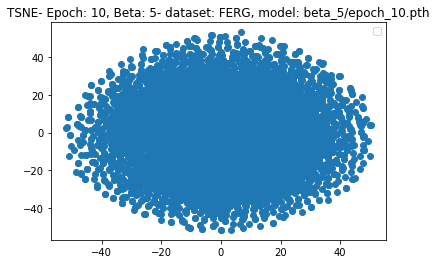

In [12]:
ds_betas = {'CelebA':[1, 250], 'Chairs':[1,5], 'DSprites':[1,5, 100], 'FERG':[1,5]}
for d in ds_betas.keys():
    for b in ds_betas[d]:
        get_results_by_model_name(d, embedded_method='TSNE', beta=b, epoch=10)
